In [1]:
import numpy  as np
import healpy as hp
import time

In [3]:
import sys
sys.path.append('/home/jthwaites/FRB/skylab_csky_comp')
#sys.path

['/home/jthwaites/FRB',
 '/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python37.zip',
 '/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7',
 '/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/lib-dynload',
 '',
 '/home/jthwaites/.local/lib/python3.7/site-packages',
 '/mnt/lfs7/user/jthwaites/FIRESONG',
 '/mnt/lfs7/user/jthwaites/CosmoloPy',
 '/mnt/lfs7/user/jthwaites/csky',
 '/mnt/lfs7/user/jthwaites/skylab',
 '/mnt/lfs7/user/jthwaites/pycondor',
 '/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/pyFFTW-0.11.1-py3.7-linux-x86_64.egg',
 '/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/src/jupyter-core',
 '/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/IPython/extensions',
 '/home/jthwaites/.ipython',
 '/home/jthwaites/FRB/skylab_csky_comp']

In [4]:
from skylab.priors        import SpatialPrior
from config_GW            import config
from scipy.optimize       import curve_fit
from skylab.ps_injector   import PointSourceInjector
from scipy.stats          import chi2

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import csky as cy

Could not import from icecube, coordinate operations will not be possible


In [7]:
mpl.rcParams['font.size'] = 20
import setup
import chime_localizations as loc

Setting up Analysis for:
GFU_for_2011_2012_2013_2014_2015_2016_2017_2018_2019
Setting up GFU_for_2011_2012_2013_2014_2015_2016_2017_2018_2019...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [63]:
###################### CONFIGURE LLH  ########################
seasons = ['GFU_v002p06','IC86, 2011-2019']
time_window = 1. # in days
erange  = [0,10]
index = 2.
nside=512

############# FRB SKYMAP ###############
frbs=setup.load_frbs(spatial_priors=True)
#spatial prior: use FRB20190416A, dec=33.3
wn=np.where(frbs['src']=='FRB20190416A')
wn=wn[0][0] #want only one of the bursts

### Read map and get probabilities
frb_probs, msk=loc.make_healpix_map('FRB20190416A', new_nside=nside, max_cl=0.9997)

src=setup.sources(86400., frbs['mjd'].values[wn]-(2*365.25), frbs['ra_deg'].values[wn], 
                  frbs['dec_deg'].values[wn])
time_mask = [time_window/2, src['mjd']]
"""some issue w dataset : max exp time is 2017-05?"""

In [64]:
print('time range: %.1f - %.1f'%(time_mask[1]-time_mask[0],time_mask[1]+time_mask[0]))

time range: 57858.2 - 57859.2


In [11]:
### Set up spatial prior to be used in scan
spatial_prior = SpatialPrior(frb_probs,allow_neg=True,interpolated_ts_norm=True)

"""Keys for spatial prior in skylab
p : np.ndarray, list of np.ndarray
    Healpix map(s) in the form of a numpy array(s) where each entry
    represents the probability for finding a point source at each
    pixel location.
log_p : np.ndarray, list of np.ndarray
    Natural logarithm of 'p' attribute
nprior : int
    Number of prior maps. One source will be injected for each
    prior map during sample()
nside : int
    Nside of the prior map
npix : int
    Number of pixels in the prior map
pixels : list
    List of pixel id numbers in map
ts_norm : list
    Normalization of the TS term for the prior(s). This equals
    the log of the max prior value and is subtracted from
    log(prior) under the ts() function to ensure the prior
    always acts as a penalty term <= 0.
"""
#spatial_prior.log_p[0][spatial_prior.log_p[0]>-20]-spatial_prior.ts_norm
spatial_prior.ts_norm

array([8.64454566])

In [14]:
"""Maps for spatial prior visualization"""
prior=spatial_prior.log_p[0]-spatial_prior.ts_norm
#set min to be -35 to get similar map to csky
prior_map=prior
w=np.where(prior_map<-35.)[0]
for p in w: prior_map[p]=-35.

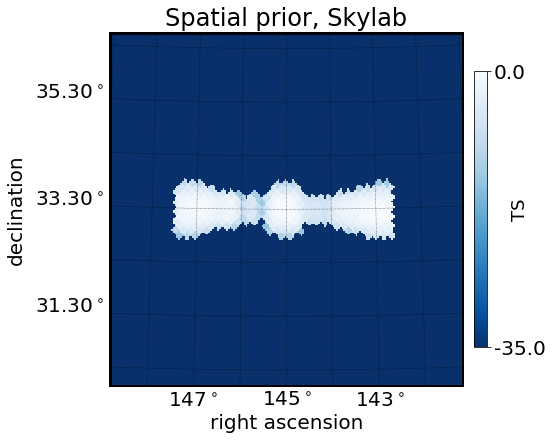

In [17]:
setup.plot_zoom(prior_map, src['ra'][0], src['dec'][0], contour_scan=False, 
                title='Spatial prior, Skylab', ts_range=[-35.,0.],
                reso=2., col_label=r"TS", cmap='Blues')

In [65]:
llh = config(seasons,ncpu=7, days=5,timescramble=True, time_mask=time_mask, poisson=True)

In [66]:
print('time range of exp data: %.1f - %.1f'%(min(llh.exp['time']),max(llh.exp['time'])))

time range of exp data: 55694.4 - 57891.2


In [67]:
val = llh.scan(0.0,0.0, scramble = True, seed = 6,spatial_prior=spatial_prior,
                    time_mask = time_mask, pixel_scan=[nside,3.0]) #mask in pixel scan
val

Process Process-120:
Process Process-121:
Process Process-122:
Process Process-123:
Process Process-124:


KeyboardInterrupt: 

Process Process-125:
Process Process-126:
Traceback (most recent call last):
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/lfs7/user/jthwaites/skylab/skylab/utils.py", line 1342, in wrapper
    val = [func(*a[0], **a[1]) for a in args]
  File "/mnt/lfs7/user/jthwaites/skylab/skylab/utils.py", line 1342, in <listcomp>
    val = [func(*a[0], **a[1]) for a in args]
  File "/mnt/lfs7/user/jthwaites/skylab/skylab/base_llh.py", line 2101, in fit_source_wrapper
    **kwargs
  File "/mnt/lfs7/user/jthwaites/skylab/skylab/base_llh.py", line 1632, in fit_source
    src_extension=src_extension)
  File "/mnt/lfs7/user/jthwaites/skylab/skylab/ps_llh.py", line 548, in _select_events
    mode=self.mode, ind=ind)
  F

  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/scipy/optimize/lbfgsb.py", line 335, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/scipy/optimize/lbfgsb.py", line 199, in fmin_l_bfgs_b
    **opts)
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/scipy/optimize/lbfgsb.py", line 335, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/scipy/optimize/lbfgsb.py", line 335, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/scipy/optimize/lbfgsb.py", line 285, in func_and_grad
    f = fun(x, *args)
  File "/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/scipy/optimize/lbfgsb.py", 

KeyboardInterrupt


In [44]:
###multiple trials:
### Set range of for loop so that multiple jobs 
### on the cluster will still all have unique seeds

pid=0 #raamis default
ntrials=1000 #raamis default
stop = ntrials * (pid+1)
start = stop-ntrials

tsList = []
for i in range(start,stop):
    val = llh.scan(0.0,0.0, scramble = True, seed = i,spatial_prior=spatial_prior,
                    time_mask = time_mask, pixel_scan=[nside,3.0]) #mask in pixel scan
    try:
        tsList.append(val['TS_spatial_prior_0'].max())
    except ValueError:
        tsList.append(-np.inf)
    if (i+1)%100==0: print('Done %i / %i'%(i, ntrials))
#np.save('/home/rhussain/icecube/dump/gw%s/bkgTrials/maxTS_%s.npy' 
#    %(args.gw,args.pid), tsList)

Done 100 / 1000
Done 200 / 1000
Done 300 / 1000
Done 400 / 1000
Done 500 / 1000
Done 600 / 1000
Done 700 / 1000
Done 800 / 1000
Done 900 / 1000


In [45]:
tsList

[-inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,